In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tslearn.clustering import KShape
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.utils import to_time_series_dataset
import folium
from folium.plugins import MarkerCluster
import branca.colormap as cm
import branca

# 데이터 로드 및 전처리
df = pd.read_csv('ELG_Busan_PoC_per_CA_site_0226_0519.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])

# 1시간 간격으로 데이터 리샘플링
df_hourly = df.set_index('timestamp').groupby('enbid_pci').resample('1h').agg({'RBused': 'mean'}).reset_index()

# 요일 및 시간 정보 추가
df_hourly['day_of_week'] = df_hourly['timestamp'].dt.dayofweek
df_hourly['hour'] = df_hourly['timestamp'].dt.hour
df_hourly['is_weekend'] = df_hourly['day_of_week'].isin([5, 6])

# 일주일 동안의 시간별 트래픽 패턴 생성
weekly_pattern = df_hourly.groupby(['enbid_pci', 'day_of_week', 'hour'])['RBused'].mean().unstack(level=[1,2])
weekly_pattern.columns = [f'day{day}_hour{hour}' for day, hour in weekly_pattern.columns]

# enbid_pci별 위치 정보 추출 (중복 제거)
location_info = df[['enbid_pci', 'ru_svc_lat_val', 'ru_svc_lng_val']].drop_duplicates('enbid_pci').set_index('enbid_pci')

# weekly_pattern에 위치 정보 추가
weekly_pattern = weekly_pattern.join(location_info)

# k-Shape 클러스터링을 위해 시계열 데이터를 3차원 배열로 변환
time_series_data = to_time_series_dataset(weekly_pattern.fillna(0).values)


# 시계열 데이터를 정규화
scaler = TimeSeriesScalerMeanVariance(mu=0., std=1.)  # 평균을 0, 분산을 1로 맞춤
time_series_data_scaled = scaler.fit_transform(time_series_data)



/var/folders/6y/gvfh979s4nb35bcvpht0ntlm0000gn/T/ipykernel_2863/3298570986.py:17: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df.set_index('timestamp').groupby('enbid_pci').resample('1H').agg({'RBused': 'mean'}).reset_index()


In [29]:
# k-Shape 클러스터링 수행
n_clusters = 4  # 클러스터 수는 필요에 따라 조정 가능
kshape = KShape(n_clusters=n_clusters, random_state=42)
cluster_labels = kshape.fit_predict(time_series_data_scaled)

# 결과를 원본 데이터에 추가
weekly_pattern['cluster'] = cluster_labels
cluster_means = weekly_pattern.groupby('cluster').mean()

print("클러스터링 완료. 각 클러스터의 크기:")
print(weekly_pattern['cluster'].value_counts())

클러스터링 완료. 각 클러스터의 크기:
cluster
1    220
3    166
2    161
0     99
Name: count, dtype: int64


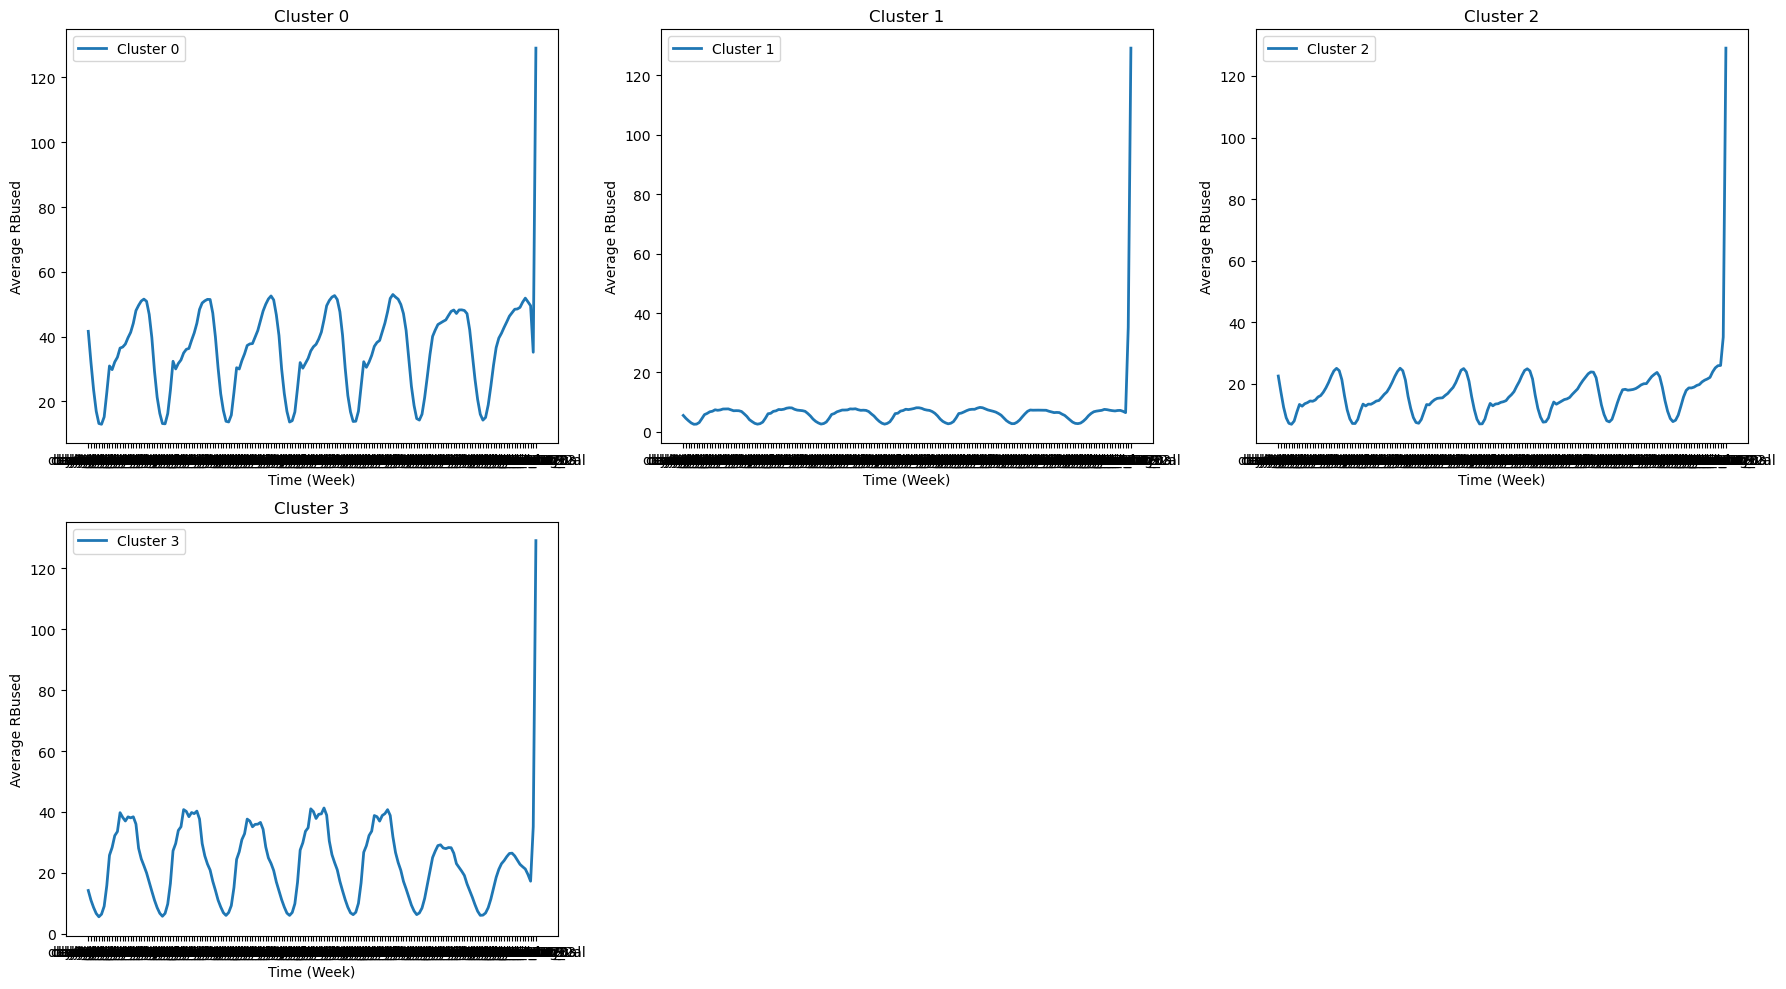

In [30]:
# 클러스터별 평균을 서브플롯으로 시각화
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))  # 서브플롯을 2x3 형태로 배열
axes = axes.flatten()  # 축을 1차원 배열로 평탄화하여 접근하기 쉽게 함

for cluster_num in range(n_clusters):
    axes[cluster_num].plot(cluster_means.iloc[cluster_num], label=f'Cluster {cluster_num}', linewidth=2)
    axes[cluster_num].set_title(f'Cluster {cluster_num}')
    axes[cluster_num].set_xlabel('Time (Week)')
    axes[cluster_num].set_ylabel('Average RBused')
    axes[cluster_num].legend()

# 빈 서브플롯 제거
for i in range(n_clusters, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


In [ ]:
# 지도 시각화
center_lat = weekly_pattern['ru_svc_lat_val'].mean()
center_lng = weekly_pattern['ru_svc_lng_val'].mean()
m = folium.Map(location=[center_lat, center_lng], zoom_start=12)

colors = ['#FF0000', '#00FF00', '#0000FF', '#FFFF00', '#FF00FF', '#00FFFF',
          '#800000', '#008000', '#000080', '#808000', '#800080', '#008080',
          '#FFA500', '#FFC0CB', '#40E0D0', '#FF69B4', '#7B68EE', '#98FB98', '#DDA0DD']

for idx, row in weekly_pattern.iterrows():
    folium.CircleMarker(
        location=[row['ru_svc_lat_val'], row['ru_svc_lng_val']],
        radius=10,
        popup=f"enbid_pci: {idx}, Cluster: {row['cluster']}",
        color=colors[int(row['cluster']) % len(colors)],
        fill=True,
        fillColor=colors[int(row['cluster']) % len(colors)],
        fillOpacity=0.7,
        stroke=True,
        weight=2
    ).add_to(m)

# 범례 추가
legend_html = '''
    <div style="position: fixed; 
    top: 50px; right: 50px; width: 120px; height: 180px; 
    border:2px solid grey; z-index:9999; font-size:14px;
    ">&nbsp; <b>Cluster Legend</b> <br>
'''
for i in range(n_clusters):
    legend_html += f'<i class="fa fa-circle fa-1x" style="color:{colors[i]}"></i>&nbsp; Cluster {i}<br>'
legend_html += '</div>'
m.get_root().html.add_child(folium.Element(legend_html))

# 지도 저장
m.save("kshape_cluster_map.html")